# Earthquake Occurrence Statistics

The statistics of earthquake occurrence is revealed from catalogs of seismicity, which include event time, location and magnitude. We will talk about how earthquakes are located and how magnitudes are estimated separately, and for now it is sufficient to know that this information can be easily acquired. With such catalogs it is possible to compare the seismic activity of different regions, make informed assessments about the frequency of earthquake occurrence, and learn about the fault rupture process. Maps of the earthquakes in catalogs over time reveal the structure of faulting in a region, and provide a framework with which to study the seismotectonics of a region.

There are two primary earthquake statistics used by seismologists. They are the Gutenberg-Richter relationship (Gutenberg and Richter, 1949), and the Omori Law (REF). 

Gutenberg and Richter found that when the logarithm of the number of earthquakes is plotted vs. magnitude that the distribution my be plotted as the line, log(N)=A+Bm, where N is the number of earthquakes, m is the magnitude and A and B are the slope and intercept of a line, refered to as the Gutenberg-Richter statistics or coefficients. They found that on a global scale, and subsequently more generally that the B-value or the slope of the Gutenberg-Richter line is approximately equal to -1. Thus for each increase in earthquake magnitude there are approximately 10 times fewer earthquakes. If for example there are 100 M3 events in a region each year Gutenberg-Richter generally finds that there would be approximately 10 M4, and 1 M5 events in each year, and for magnitudes larger than M5 there would be fewer than one event per year. Gutenberg-Richter is a very important statistic for this reason as it is used to determine the rates of earthquake occurrence which is a key step in characterizing earthquake hazards (problems for future homework exercises). 

The Omori Law is used to characterize the rate at which aftershocks occur following a large mainshock event. This statistic is used for comparing the aftershock productivity of different earthquakes and regions, make forecasts of the likelihood of large damaging aftershocks and to distinguish between earthquake faulting and possibly geothermal or volcanic related seismicity by examining whether the distribution describes a mainshock/aftershock pattern or is more swarm like. 

In this homework you will use this python notebook to investigate the Gutenberg-Richter and Omori statistics for the San Francisco Bay Area, as well as develop numerical analysis skills using python. This is not a python class, but the primary programming tool that will be used is python, however if you know MatLab or have other programing background you are free to use those tools if you prefer. It will be helpful to read sections 9.6 and 9.8 of Lay and Wallace (1995) prior to working on this laboratory for background on Gutenberg-Richter and Omori Law.

In [2]:
#Initial Setup and Subroutine Definitions
import math
import datetime
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

#This function computes the spherical earth distance between to geographic points and is used in the
#declustering algorithm below
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c
    return km



### The Catalog
We have downloaded the Advanced National Seismic System (ANSS) catalog from 1900 to 2018 for you to use. The file is named "anss_catalog_1900to2018all.txt" The catalog includes information about the date and time of the earthquake, the location and the magnitude. This catalog has all events in the aforementioned time range located within 100 km of UC Berkeley. The following python code reads this catalog file and places the information in arrays for analysis.

In [3]:
#read data and create data arrays
# This catalog is a M0+ search centered at Berkeley radius=100. Big enough to include Loma Prieta but exclude Geysers
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None)
#data=pd.read_csv('testcat2.txt', sep=' ', delimiter=None, header=None)
d=np.array(data)
year=d[:,0].astype(int)
month=d[:,1].astype(int)
day=d[:,2].astype(int)
hour=d[:,3].astype(int)
mn=d[:,4].astype(int)
sec=d[:,5].astype(int)
lat=d[:,6]
lon=d[:,7]
mag=d[:,8]
nevt=len(year)

### Exercise 1
Make and x-y plot showing the magnitude of the earthquake on the y-axis and the time of the event on the x-axis. For this it is useful to determine the days since the beginning of the catalog. The plot will show that the catalog is not uniform due to the fact that over time as more seismic recording stations were installed more earthquakes could be detected and properly located.

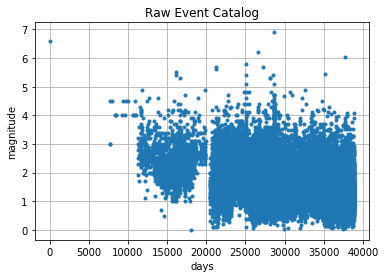

Number=69804 MinMag=0.00 MaxMag=6.90


In [4]:
#Determine the number of days from the first event and plot magnitude vs. time
days=np.zeros(nevt)
for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days
    
fig, ax = plt.subplots()
ax.plot(days, mag,'.')
ax.set(xlabel='days', ylabel='magnitude',
       title='Raw Event Catalog')
ax.grid()

fig.savefig("figure1.png")
plt.show()

print(f'Number={nevt:d} MinMag={min(mag):.2f} MaxMag={max(mag):.2f}')

### Exercise 2
Plot the catalog in map view. Familiarize yourself with the code example below as there will be additional exercises requiring the plotting of maps.

- Describe the seismicity and any patterns that you see.
- Try adding fault traces.
- How well does the seismicity show the region's major faults?

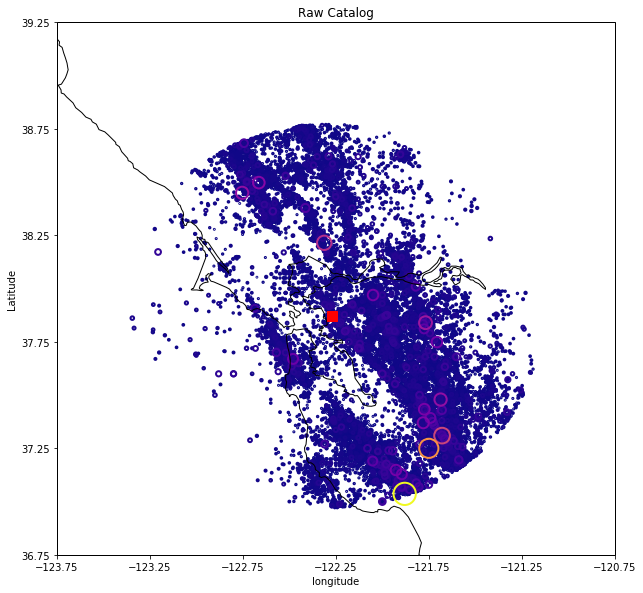

In [39]:
#Make a Map

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width
###
###
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Raw Catalog')

#ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAKES,alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.STATES.with_scale('10m'))

x=lon
y=lat
z=mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors='none', edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=10)

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('seismap_raw.pdf')
plt.savefig('seismap_raw.png')

plt.show()

### Exercise 3

Compute the Gutenberg Richter statics for the raw catalog. 

1) First define a range of magnitudes to bin the data. You can use a range of magnitude, m from 0.0 to 6.9 in increments of 0.1 magnitude unit. 

2) Next count the number of events above a given magnitude. That is count the number of events above and equal to magnitude 0.0, then above and equal to 0.1, and so forth all the way to the maximum magnitude. You can do this by placing the code for vectorized counting of array elements passing a logical test (numpy.count_nonzero()) inside a for loop over the incremental magnitudes, m.

3) We are interested in the annual rate of the events so you will need to divide by the total number of years the catalog spans.

4) Take the log base 10 (numpy.log10) of the annual number of earthquakes for each magnitude bin. Note you can place all of the operations in (2), (3) and (4) in a single code line inside the for loop.

Fit the Gutenberg Richter relationship log10(N)=A+Bm to the data. In other words invert the data to find the applied model parameters.

1) This is done by creating a matrix, A, which has one column of 1s and a second column of the magnitudes, m.

2) Create a single column data matrix, D, which has the log10(N(m) values

3) Compute the ATA (A transpose times A) matrix using numpy functions

4) Compute the ATD (A transpose times D)

5) Invert the equation (ATA)x=ATD using the numpy linear algebra solver (numpy.linalg.solv()). The result, x, will have the A-value=x[0] and the B-value=x[1]. The values you should get are A=3.418 and B=-0.809.

Make a plot showing the distribution of the log10(N) vs m, and the best fit line. The following figure is an example of what you should get.

<img src="./figure2.png">

Compute the uncertainties of the model. This can be done by estimating the 95% confidence levels by using the students t-test. The following outlines how this is done using the numpy and scipy packages.

#Compute 95% confidence levels using the following steps

1) df=(length_of_data) - (number_of_model_parameters) #degree of freedom

2) e=data-(model predictions) #prediction error

3) variance=np.sum(e*e)/df

4) se_y=np.sqrt(var)                       #standard error of the estimate

5) sdev=np.sqrt(var)                       #standard deviation

#Calculate 95% confidence bounds

6) t=stats.t.ppf(1-0.05/2,degfree)             #two-sided students t-distribution

7) lower95=np.exp(np.log(modeled_pga)-t*se_y)

8) upper95=np.exp(np.log(modeled_pga)+t*se_y)

9) standard error of slope

10) standard error of intercept (9 and 10 will be important for incorporating Gutenberg Richter uncertainty in PSHA (a future homework)



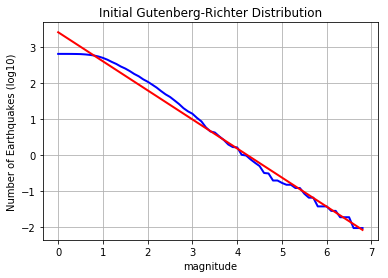

A_value= 3.418 B_value=-0.809


In [40]:
#Determine and plot the Initial Gutenberg-Richter Distribution
m=np.arange(0.,6.9,0.1)
N=np.zeros(len(m))
len(m)

numyr=(max(days)-min(days))/365
for i in range(0,len(m),1):
    N[i]=np.log10(np.count_nonzero(mag >= m[i])/numyr)
 

#Invert for A and B values
tmp=np.ones(len(N))
A=np.column_stack((tmp,m))
ATA=np.dot(np.transpose(A),A)
ATD=np.dot(np.transpose(A),N)
soln=np.linalg.solve(ATA,ATD)
x=m
y=np.dot(A,soln)

#Now Plot
fig, ax = plt.subplots()
ax.plot(m, N,'b-',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()

fig.savefig("figure2.png")
plt.show()


print(f'A_value= {soln[0]:.3f} B_value={soln[1]:.3f}')
    

### Questions

1. How well does the Gutenberg-Richter model fit the data?
2. Where does the fit begin to breakdown and why?
3. Based on your Gutenberg-Richter coefficients what is the annual rates of a M4 earthquake? For a M7 earthquake?
4. On average how may years are there between M7 earthquakes based on this catalog.
5. How may M7 earthquakes are in the catalog?
6. What is your assessment of the quality or suitability of the forecast of average M7 occurrence?

### Exercise 3

In the above analysis mainshocks (primary events) and aftershocks are mixed together. The results were pretty good, however a correct implementation of Gutenberg-Richter considers only the primary events, and therefore a catalog with aftershocks removed is needed. The process to remove aftershocks is called declustering.

In this exercise you will decluster the catalog, evaluating several different published methods of declustering (see following block), and compute the Gutenberg-Richter coefficients for each declustered catalog to examine the variablity in the estimated parameters due to the different declustering algorithms.

<img src="files/example_grfit2.png">

### Declustering the Catalog

The analysis that was just performed was for the raw catalog, which means that it includes all events. However Gutenberg-Richter is really interested in the occurrence of primary events, and therefore it is necessary to decluster or remove aftershocks from the catalog. This is done using an algorithm that relates the expected time and distance range of aftershocks from a given mainshock. For a larger mainshock aftershocks will be found to occur over a longer period of time, and at greater distance from the mainshock, than for a smaller mainshock. The block below defines a declustering algorithm. The 'Dtest' and 'Ttest' are magnitude dependent distance and time metrics. If a given event falls within the maximal values defined by Dtest and Ttest for a given earthquake it is then removed from the catalog. The remaining catalog is then comprised of primary events and a more accurate Gutenberg-Richter statistic can be estimated. Furthermore the events that are removed give the aftershocks for a given earthquake, which can be used for examining the Omori Law statistics.

The relationships to compute the distance and time windows to identify aftershocks (the Dtest and Ttest functions above) were proposed by Knopoff and Gardner (1972). There are other relationships.

Compare the event reduction rate (final number divided by the initial number of events) for the different proposed distance and time windows on page 10 of Stiphout et al. (2012). You can do this by adding a logical (if statement) tree to enable switching between different definitions of Dtest and Ttest in the 'Decluster the catalog' code block below.

The alternative functions from vanStiphout et al. (2012) are as follows, where M is magnitude, d is the Dtest in km, and t is Ttest in days.

<img src="./vanStiphout.png">

In [5]:
#Decluster the Catalog  Note: This cell may take a few minute to complete
cnt=0
save=np.zeros((1,10000000),dtype=int)
for i in range(0,nevt,1):
    #You can add logical if statements to incorporate different definitions of Dtest and Ttest here see Exercise 3
    Dtest=np.power(10,0.1238*mag[i]+0.983)
    if mag[i] >= 6.5:
        Ttest=np.power(10,0.032*mag[i]+2.7389)
    else:
        Ttest=np.power(10,0.5409*mag[i]-0.547)
    
    a=days[i+1:nevt]-days[i]
    m=mag[i+1:nevt]
    b=haversine_np(lon[i],lat[i],lon[i+1:nevt],lat[i+1:nevt])
    
    icnt=np.count_nonzero(a <= Ttest)
    if icnt > 0:
        itime=np.array(np.nonzero(a <= Ttest)) + (i+1)
        for j in range(0,icnt,1):             
            if b[j] <= Dtest and m[j] < mag[i]:
                save[0][cnt]=itime[0][j]
                cnt += 1

                
save=np.delete(np.unique(save),0)   #Note this is an array of indexes that will be used to delete events flagged 
                                    #as aftershocks    

In [7]:
np.shape(save)

(45563,)

### Questions

1. How many events were removed from the catalog?

2. Make a plot showing a map of the declustered catalog and compare the spatial distribution of earthquakes between the raw and declustered catalogs.

3. For the two other methods of declusting how many events were removed from the catalog?

In [42]:
#Write your code to determine the Gutenberg Richter parameters on the declustered catalog here.

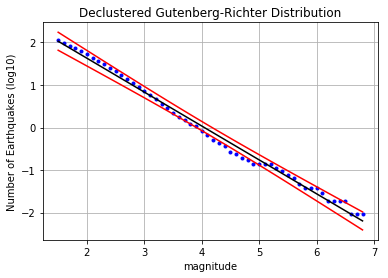

A_value= 3.221 B_value=-0.797
95%intercept= 0.082 95%slope=0.018


In [43]:
#Determine and plot the Gutenberg-Richter Distribution for DeClustered Data
#You may want to adjust the magnitude range of the analysis to focus on where the catalog is complete
m=np.arange(1.5,6.9,0.1)
N=np.zeros(len(m))

for i in range(0,len(m),1):
    N[i]=np.log10(np.count_nonzero(dm >= m[i])/numyr)
 

#Invert for A and B values
tmp=np.ones(len(N))
A=np.column_stack((tmp,m))
ATA=np.dot(np.transpose(A),A)
ATD=np.dot(np.transpose(A),N)
soln=np.linalg.solve(ATA,ATD)
x=m
y=np.dot(A,soln)

#Compute the uncertainty in Gutenberg-Richter Parameters

df=len(N) - 2                 #degree of freedom
e=N-y                         #prediction error
var=np.sum(e**2)/df
se_y=np.sqrt(var)             #standard error of the estimate
sdev=np.sqrt(var)             #standard deviation

#Calculate 95% confidence bounds
t=stats.t.ppf(1-0.05/2,df)    #two-sided students t-distribution
tmp=np.sqrt(1/len(x)+((x-np.mean(x))**2)/np.sum((x-np.mean(x))**2))
tmp=tmp/max(tmp)
lower95=y-t*se_y*tmp
upper95=y+t*se_y*tmp
se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2))                      #standard error slope
se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) #standard error of intercept
a95=se_a*t
b95=se_b*t

#Now Plot
fig, ax = plt.subplots()
ax.plot(m, N,'b.',x,y,'k-',x,lower95,'r-',x,upper95,'r-')
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Declustered Gutenberg-Richter Distribution')
ax.grid()

fig.savefig("figure4.png")
plt.show()


print(f'A_value= {soln[0]:.3f} B_value={soln[1]:.3f}')
print(f'95%intercept= {a95:.3f} 95%slope={b95:.3f}')

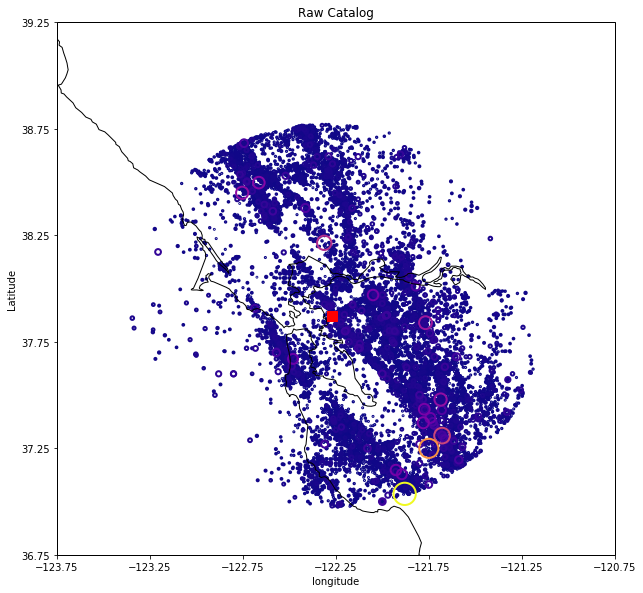

In [44]:
#Make a Map

import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width
###
###
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Raw Catalog')

#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.STATES.with_scale('10m'))

#x=lon
#y=lat
#z=mag
x=np.delete(lon,save)
y=np.delete(lat,save)
z=np.delete(mag,save)
#Sort Descending
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size
#plt.scatter(x, y, s=z, c=z, marker='o', linewidth=1)
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors='none', edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=10)

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('seismap_declust.pdf')
plt.savefig('seismap_declust.png')

plt.show()

### Questions

1) Compare the Gutenberg-Richter A and B coefficients for the three versions of the declustered catalog.

2) What is the annual rate of occurrence of M4 earthquakes for each of the declustered catalogs?

3) What is the average M7 return period (inverse of annual occurrence of M7 events) for the each of the declustered catalogs?

4) Compare your estimated values with what has been presented in the USGS Earthquake Hazard Assessments of the return period for Hayward fault earthquakes.